### Урок 2. Бейзлайны и детерминированные алгоритмы item-item

### -- Автор: Шенк Евгений Станиславович

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
np.random.seed(42)

In [3]:
data = pd.read_csv('./data/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
data.describe()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
count,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06
mean,1.271904e+03,3.336643e+10,3.639770e+02,2.827247e+06,1.003763e+02,3.100821e+00,3.048227e+03,-5.400708e-01,1.561714e+03,5.268156e+01,-1.638696e-02,-2.897905e-03
std,7.265644e+02,4.284798e+09,1.759385e+02,3.732798e+06,1.152379e+03,4.210229e+00,8.785542e+03,1.245824e+00,4.015691e+02,2.513310e+01,2.168615e-01,3.974618e-02
min,1.000000e+00,2.698485e+10,1.000000e+00,2.567100e+04,0.000000e+00,0.000000e+00,1.000000e+00,-1.300200e+02,0.000000e+00,1.000000e+00,-5.593000e+01,-7.700000e+00
25%,6.550000e+02,3.008714e+10,2.160000e+02,9.169930e+05,1.000000e+00,1.290000e+00,3.300000e+02,-6.900000e-01,1.307000e+03,3.200000e+01,0.000000e+00,0.000000e+00
50%,1.271000e+03,3.241998e+10,3.660000e+02,1.027569e+06,1.000000e+00,2.000000e+00,3.700000e+02,-2.000000e-02,1.614000e+03,5.300000e+01,0.000000e+00,0.000000e+00
75%,1.914000e+03,3.514580e+10,5.150000e+02,1.132178e+06,1.000000e+00,3.490000e+00,4.220000e+02,0.000000e+00,1.844000e+03,7.400000e+01,0.000000e+00,0.000000e+00
max,2.500000e+03,4.165679e+10,6.630000e+02,1.802456e+07,8.963800e+04,8.400000e+02,3.428000e+04,3.990000e+00,2.359000e+03,9.500000e+01,0.000000e+00,0.000000e+00


In [5]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [6]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [7]:
def weighted_random_recommendation(items_weights, n=5):
 
    items = np.array(items_weights['item_id'])
    recs = np.random.choice(items, p=items_weights['weight'], size=n, replace=False)
    
    return recs.tolist()

In [8]:
def weights(data):
    
    popular = data.groupby('item_id')['quantity'].sum().reset_index()
    logs = np.log(popular['quantity']+1e-15)
    wg = np.array([x * (x>0) for x in logs])
    result = wg / wg.sum()
    
    return pd.DataFrame({'item_id': popular['item_id'], 'weight': result})

In [9]:
%%time

items_weights = weights(data_train)
weighted_random_recommendation(items_weights)

Wall time: 132 ms


[1004390, 13511133, 6979266, 1124128, 890344]

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [10]:
result = pd.read_csv('./data/predictions_basic.csv')
actual = data_test.groupby('user_id')['item_id'].unique().reset_index()
actual.columns=['user_id', 'actual']
result['actual'] = actual['actual'].values
result['random_recommendation'] = result['random_recommendation'].apply(lambda x: np.array([str.strip() for str in x[1:-1].split(',')]).astype(np.int))
result['popular_recommendation'] = result['popular_recommendation'].apply(lambda x: np.array([str.strip() for str in x[1:-1].split(',')]).astype(np.int))
result['itemitem'] = result['itemitem'].apply(lambda x: np.array([str.strip() for str in x[1:-1].split(',')]).astype(np.int))
result['cosine'] = result['cosine'].apply(lambda x: np.array([str.strip() for str in x[1:-1].split(',')]).astype(np.int))
result['tfidf'] = result['tfidf'].apply(lambda x: np.array([str.strip() for str in x[1:-1].split(',')]).astype(np.int))
result.iloc[[58, 511, 581, 770, 1622, 1625, 1735, 1934], result.columns.get_loc('own_purchases')] = str('[0, 0, 0, 0, 0]')
result['own_purchases'] = result['own_purchases'].apply(lambda x: np.array([str.strip() for str in x[1:-1].split(',')]).astype(np.int))
result['weighted_random_recommendation'] =  result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1046245, 410913, 6461634, 5567649, 930813]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]","[890338, 838867, 10341234, 1125491, 6464120]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1048237, 1626074, 1854651, 2553955, 43256]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]","[819748, 14077803, 9707375, 918684, 903325]"


In [11]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
       
    return precision

In [12]:
p5_random_recommendation = []
p5_popular_recommendation = []
p5_itemitem = []
p5_cosine = []
p5_tfidf = []
p5_own_purchases = []
p5_weighted_random_recommendation = []

for index, row in result.iterrows():
    bought_list = result.iloc[[index]]['actual'].values[0]
    recommended_list = (result.iloc[[index]]['random_recommendation'].values[0][:5])
    p5_random_recommendation.append(precision_at_k(recommended_list, bought_list, k=5))
    recommended_list = (result.iloc[[index]]['popular_recommendation'].values[0][:5])
    p5_popular_recommendation.append(precision_at_k(recommended_list, bought_list, k=5))
    recommended_list = (result.iloc[[index]]['itemitem'].values[0][:5])
    p5_itemitem.append(precision_at_k(recommended_list, bought_list, k=5))    
    recommended_list = (result.iloc[[index]]['cosine'].values[0][:5])
    p5_cosine.append(precision_at_k(recommended_list, bought_list, k=5))    
    recommended_list = (result.iloc[[index]]['tfidf'].values[0][:5])
    p5_tfidf.append(precision_at_k(recommended_list, bought_list, k=5))      
    recommended_list = (result.iloc[[index]]['own_purchases'].values[0][:5])
    p5_own_purchases.append(precision_at_k(recommended_list, bought_list, k=5))      
    recommended_list = (result.iloc[[index]]['weighted_random_recommendation'].values[0][:5])
    p5_weighted_random_recommendation.append(precision_at_k(recommended_list, bought_list, k=5))     

In [13]:
method = ['random_recommendation', 'popular_recommendation', 'itemitem', 'cosine', 'tfidf', 'own_purchases', 'weighted_random_recommendation']
p5 = [np.array(p5_random_recommendation).mean(),
        np.array(p5_popular_recommendation).mean(),
        np.array(p5_itemitem).mean(), 
        np.array(p5_cosine).mean(),
        np.array(p5_tfidf).mean(),
        np.array(p5_own_purchases).mean(),
        np.array(p5_weighted_random_recommendation).mean()]

result_table = pd.DataFrame({'method': method, 'precision_at_5': p5})
result_table

,method,precision_at_5
0,random_recommendation,0.000979
1,popular_recommendation,0.155240
2,itemitem,0.151224
3,cosine,0.155142
4,tfidf,0.160921
5,own_purchases,0.201126
6,weighted_random_recommendation,0.002155


### own_purchases (itemitem recomender k=1) показывает наилучший результат

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ- {2000, 5000, 10000} товаров. Постройте график зависимости precision@5 от топ-*
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$. Постройте график зависимости precision@5 от $K$ 

In [14]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

In [15]:
top = []
for i in range(1, 11):
    top.append(popularity.sort_values('n_sold', ascending=False).head(1000 * i).item_id.tolist())

In [16]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [17]:
def popularity_recommendation(data, top_list, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [18]:
def weighted_random_recommendation(items_weights, n=5):
 
    items = np.array(items_weights['item_id'])
    recs = np.random.choice(items, p=items_weights['weight'], size=n, replace=False)
    
    return recs.tolist()

In [19]:
def weights(data, top_list):
    
    popular = data.groupby('item_id')['quantity'].sum().reset_index()
    popular = popular.loc[popular['item_id'].isin(top_list)]
    logs = np.log(popular['quantity']+1e-15)
    wg = np.array([x * (x>0) for x in logs])
    result = wg / wg.sum()
    
    return pd.DataFrame({'item_id': popular['item_id'], 'weight': result})

In [20]:
data_baselines = pd.DataFrame({'user_id': result['user_id'], 'actual': result['actual']})

In [21]:
%%time
# rnd, pop, wrr
for i in range(0, 10):
    data_baselines[f'rnd_top_{i}k'] =  data_baselines['user_id'].apply(lambda x: random_recommendation(items=top[i], n=5))
    popular_recs = popularity_recommendation(data_train, top_list=top[i], n=5)
    data_baselines[f'pop_top_{i}k'] =  data_baselines['user_id'].apply(lambda x: popular_recs)
    items_weights = weights(data_train, top_list=top[i])
    data_baselines[f'wrr_top_{i}k'] =  data_baselines['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))

Wall time: 11.4 s


In [22]:
data_baselines.head(2)

,user_id,actual,rnd_top_0k,pop_top_0k,wrr_top_0k,rnd_top_1k,pop_top_1k,wrr_top_1k,rnd_top_2k,pop_top_2k,...,wrr_top_6k,rnd_top_7k,pop_top_7k,wrr_top_7k,rnd_top_8k,pop_top_8k,wrr_top_8k,rnd_top_9k,pop_top_9k,wrr_top_9k
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[909268, 900072, 1139830, 1020581, 961554]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999858, 1113588, 1050229, 823758, 849202]","[831536, 874972, 1099089, 880253, 821083]","[6534178, 6533889, 1029743, 6534166, 1082185]","[835098, 948232, 1137688, 1034686, 1037894]","[993685, 990656, 935570, 12524323, 900418]","[6534178, 6533889, 1029743, 6534166, 1082185]",...,"[841220, 6979545, 923208, 1096635, 1120443]","[9881948, 906658, 923528, 889511, 2690723]","[6534178, 6533889, 1029743, 6534166, 1082185]","[819978, 901840, 1003699, 868745, 880423]","[1080821, 904373, 934653, 873622, 9245108]","[6534178, 6533889, 1029743, 6534166, 1082185]","[10149761, 1053690, 1007959, 1090621, 12188583]","[6602729, 14043826, 989703, 852437, 1009344]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1002838, 904360, 886621, 873654, 1091926]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[837270, 1084331, 879528, 1119761, 5712216]","[6534178, 6533889, 1029743, 6534166, 1082185]","[991379, 1029968, 985999, 964356, 822785]","[932242, 940726, 1123014, 995134, 905986]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1075707, 1072523, 986760, 847344, 1034837]","[873902, 871754, 12731641, 854483, 991844]","[6534178, 6533889, 1029743, 6534166, 1082185]",...,"[848561, 7126663, 8119004, 5995483, 900586]","[1018740, 988697, 909479, 12301338, 1003497]","[6534178, 6533889, 1029743, 6534166, 1082185]","[869054, 1030362, 1066893, 731106, 1005583]","[1047923, 5564526, 855310, 9420282, 1043142]","[6534178, 6533889, 1029743, 6534166, 1082185]","[913997, 848015, 987148, 847901, 1098248]","[1000728, 1015548, 9803371, 1032584, 5566956]","[6534178, 6533889, 1029743, 6534166, 1082185]","[909915, 870018, 1029513, 988572, 397896]"


In [23]:
p5_rnd = []
p5_pop = []
p5_wrr = []
for i in range(0, 10):
    p5_rnd.append(data_baselines.apply(lambda row: precision_at_k(row[f'rnd_top_{i}k'], row['actual'], k=5), axis=1).mean())
    p5_pop.append(data_baselines.apply(lambda row: precision_at_k(row[f'pop_top_{i}k'], row['actual'], k=5), axis=1).mean())
    p5_wrr.append(data_baselines.apply(lambda row: precision_at_k(row[f'wrr_top_{i}k'], row['actual'], k=5), axis=1).mean())

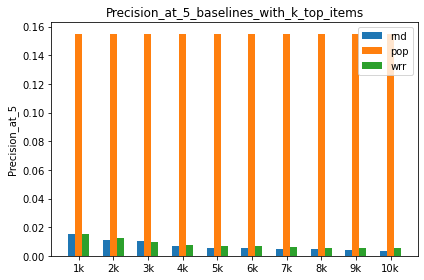

In [24]:
labels = [f'{i}k' for i in range (1, 11)]
x = np.arange(len(labels))
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x-width, p5_rnd, width, label='rnd')
rects2 = ax.bar(x, p5_pop, width, label='pop')
rects3 = ax.bar(x+width, p5_wrr, width, label='wrr')

ax.set_ylabel('Precision_at_5')
ax.set_title('Precision_at_5_baselines_with_k_top_items')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

##### Popularity-based recommendation - никак не меняется
##### У Random recommendation и Weighted random recommender качество растет при уменьшении количества позиций товаров в топе.


### ItemItem

In [25]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [26]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

C:\Users\Eugene\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [27]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [28]:
data_itemitem = pd.DataFrame({'user_id': result['user_id'], 'actual': result['actual']})

In [29]:
%%time

K_list = [2, 3, 4, 5, 7, 10, 15]

for i in K_list:
    model = ItemItemRecommender(K=i, num_threads=4) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    data_itemitem[f'itemitem_k_{i}'] = data_itemitem['user_id'].\
        apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                        model.recommend(userid=userid_to_id[x], 
                                        user_items=sparse_user_item,   # на вход user-item matrix
                                        N=5, 
                                        filter_already_liked_items=False, 
                                        filter_items=[itemid_to_id[999999]], 
                                        recalculate_user=False)])


Wall time: 3.86 s


In [30]:
data_itemitem.head(2)

,user_id,actual,itemitem_k_2,itemitem_k_3,itemitem_k_4,itemitem_k_5,itemitem_k_7,itemitem_k_10,itemitem_k_15
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 995242, 1029743, 840361, 904360]","[1082185, 981760, 995242, 1029743, 840361]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 995242, 840361, 1127831]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1082185, 1098066, 6534178, 826249, 1127831]","[1082185, 981760, 1098066, 6534178, 826249]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]"


In [31]:
p5_itemitem = []
for i in K_list:
    p5_itemitem.append(data_itemitem.apply(lambda row: precision_at_k(row[f'itemitem_k_{i}'], row['actual'], k=5), axis=1).mean())

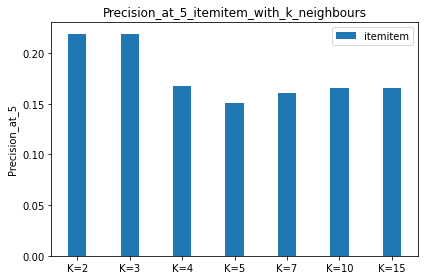

In [32]:
labels = [f'K={i}' for i in K_list]
x = np.arange(len(labels))
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, p5_itemitem, width, label='itemitem')

ax.set_ylabel('Precision_at_5')
ax.set_title('Precision_at_5_itemitem_with_k_neighbours')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

##### При уменьшении количества соседей Precision_at_5 вырос.